##Topic modeling

In [1]:
!pip -q install sentence-transformers
!pip -q install hdbscan
!pip -q install transformers
!pip -q install langdetect

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 1.1MB 9.0MB/s 
     |████████████████████████████████| 1.1MB 22.5MB/s 
     |████████████████████████████████| 890kB 39.7MB/s 
     |████████████████████████████████| 3.0MB 44.8MB/s 
     |████████████████████████████████| 4.7MB 5.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 983kB 5.2MB/s 


### Import Libraries

In [66]:
from sklearn.datasets import fetch_20newsgroups
import pickle
import pandas as pd
import numpy as np
import nltk
import string
import re
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from langdetect import detect


model = SentenceTransformer('distilbert-base-nli-mean-tokens')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import requests

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data preprocessing

In [80]:
def filtering(row):
  

  #s=re.sub(r'\d+', '', row['Description'])
  s=row['Description']
  lemmatizer = WordNetLemmatizer() 
  porter = PorterStemmer()
  stop_words = set(stopwords.words('english')) 

  #Tokenization
  word_tokens=nltk.word_tokenize(s.lower())
  #remove stop words
  filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  #remove punctuatio
  filtered_sentence = [w for w in filtered_sentence if not w in string.punctuation] 
  #stemming
  filtered_sentence = [porter.stem(w) for w in filtered_sentence]
  #lemmatization
  filtered_sentence = [lemmatizer.lemmatize(w) for w in filtered_sentence]

  return " ".join(filtered_sentence)

def detect_language(row):
    try:
      return detect(row["Description"])
    except:
      return None

df=pd.read_csv("Data_Startups.csv")
df.drop_duplicates(subset ="Name", 
                     keep = False, inplace = True) 
#df["language"]=df.apply(detect_language,axis=1)
df['Description_cleaned'] = df.apply(filtering, axis=1) 
docs=df['Description']
urls=df['urlwebsite']

docs_cleaned=df['Description_cleaned']
#dropping row containing non-english words
df.head(10)

,Name,urlwebsite,keywords,Description_French,Description,Description_cleaned
0,medeo,https://www.medeo-health.com/,digital / e-santé / objets connectés / santé,Simplifier le quotidien des professionnels de ...,Simplifying the lives of health professionals ...,simplifi live health profession use telemedici...
1,co-cto,https://www.co-cto.fr/,Accompagnement / application / Application eCo...,CO-CTO met au service des startups et PME des ...,CO-CTO at the service experienced startups and...,co-cto servic experienc startup sme cto timeshar
2,curvway,http://curvway.com,mobilité / SportTech,Conception de planches électriques qui permett...,Design of electrical boards that allow to reca...,design electr board allow recal feel snowboard...
3,ecosiag,http://www.ecosiag.com,B2B / Bpifrance / Alimentation saine et durabl...,Développement de fermes urbaines aquaponiques ...,Development of automated aquaponic urban farms,develop autom aquapon urban farm
4,mylabel,https://www.mylabel.io/,NaN,L'appli qui vous permet de consommer selon vos...,The app allows you to eat according to your va...,app allow eat accord valu
5,freelance-stackio,https://www.freelance-stack.io,Boîte à outils startup / Developer Tools (outi...,Freelance-Stack.io : outils & solutions pour f...,Freelance-Stack.io: tools & solutions for free...,freelance-stack.io tool solut freelanc indepen...
6,praxis-web,https://praxisweb.fr,Accompagnement / creation de siteweb / référen...,Création et refonte de sites internet pour tou...,Creation and redesign websites for all public ...,creation redesign websit public craftsman soho...
7,ryax-technologies,https://ryax.tech/,big data / BtoB / logiciel / SaaS,Ryax est une plateforme de Data Engineering qu...,Ryax is a platform that helps your Data Engine...,ryax platform help data engin data team deploy...
8,angusta,https://www.per-angusta.com/fr/,Achat / SaaS,Solution Agile de pilotage des équipes et de l...,Steering Solution Agile teams and Purchasing P...,steer solut agil team purchas perform
9,optimiz-construction,http://www.optimiz-construction.fr,Construction durable / construction / optimisa...,Optimiz Construction est une solution d’optimi...,Optimiz Construction is a cut optimization sol...,optimiz construct cut optim solut steel site


### Keyword Extraction

In [39]:
keywords=set()
for words in df.keywords:
  keywords |= words

keywords

{'',
 '3D',
 'A',
 'API',
 'Abonnement',
 'Accompagnement',
 'Accélérateur',
 'Achat',
 'Activités et Loisirs',
 'Actualités',
 'Adtech',
 'Agenda',
 'AgriTech',
 'Alimentation saine et durable',
 'Analyse',
 'Android',
 'Application eCommerce',
 'Application mobile',
 'Automobile',
 'B Testing',
 'B2B',
 'BTP',
 'Bio-Eclairage',
 'Blanchisserie',
 'Blockchain',
 'Bon plan',
 'Bonnes adresses',
 'Booking',
 'Boîte à outils startup',
 'Bpifrance',
 'BtoB',
 'Business',
 'Business Intelligence',
 'CDN',
 'CRM',
 'CV',
 'Centre de formation',
 'Chasseurs de tête',
 'CleanTech',
 'Communauté',
 'Comparateur',
 "Comparateur d'assurances",
 'Compensation Carbone',
 'Computer Vision',
 'Conseil et vente de matériel',
 'Construction durable',
 'Crowdsourcing',
 'DIY',
 'Dating',
 'Detox digitale',
 'Developer Tools (outil pour développeurs)',
 'Distribution',
 'Divertissement',
 'Développement',
 'E-commerce',
 'ESS',
 'Economie circulaire',
 'Economie collaborative',
 'EdTech',
 'Efficience é

In [95]:
words={"Industrie","Infrastructure","IOT","Robotique"}
mandatory_words={"Industrie"}
df=df.dropna()
df["keywords"]=df.keywords.str.split("/").apply(lambda X: {x.strip(' ') for x in X if(x!=' ')})
data_filtered = df[df.keywords.apply(lambda X: len(words & X)>0)]
data_filtered.shape

(215, 6)

In [96]:
df_ = data_filtered[['Description','keywords','urlwebsite']]
df_.style.set_properties(subset=['Description'], **{'width': '300px'})

,Description,keywords,urlwebsite
13,Mcarré fight against planned obsolescence of computers doubling their life for individuals and professionals.,"{'Réseau', 'support', 'Infrastructure', 'services informatiques'}",http://www.mcarre.fr
124,A team of 25 experts who accompany you in all your projects and textile accessories to measure.,"{'digital', 'Industrie', 'production', 'textile'}",http://www.crafters.fr
144,MAF Quality Consulting assists companies in developing on aspects quality and safety.,"{'conseil', 'Industrie', 'Santé sécurité au travail'}",http://crgquality.wordpress.com
169,Piwio is a consulting firm based in Lyon who accompanies you on all your innovative projects. Designing objects connected to the use of their data.,"{'Software', 'big data', 'IOT', 'electronique', 'Hardware', 'objets connectés', 'Informatique', 'Développement', 'Internet des objets'}",https://www.piwio.fr/
273,Objects connected to sports.,"{'IOT', 'SportTech', 'caméra', 'objets connectés', 'Activités et Loisirs'}",https://ouivallee.com
324,Secures devices and objects connected to the Internet,"{'IOT', 'Protection', 'objets connectés', 'box', 'domotique', 'cybersecurité', 'Securité', '3D'}",https://web.uppersafe.com/fr/home
350,The first robot designed for the retail sector and hospitality,{'Robotique'},http://www.heaserobotics.com
355,design experts IoT,{'IOT'},http://rtone.fr
366,"Hoomano designs, develops and deploys software for robots interaction","{'Robotique', 'SaaS'}",http://hoomano.com
367,Autonomous droid for the last kilometer logistics city,{'Robotique'},http://www.twinswheel.fr


In [52]:
len(docs)

7184

### Data encoding

SBERT is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

For Retriveing the  BERT embeddings, we apply Encoding on clear text not cleaned one,it will give better results.
<br>
We use the cleaned text when we want to extract most important keywords in each cluster (c-tf-idf)


In [82]:
embeddings = model.encode(list(docs), show_progress_bar=True)

In [91]:
industry=model.encode(["industrial robotics and IOT"])[0]
similarity_scores = np.sum((embeddings-industry)**2, axis=1)
indices= np.argsort(similarity_scores)[:20]

frame=pd.DataFrame({})
frame["url"]=list(np.array(urls)[indices])
frame["des"]=list(np.array(docs)[indices])
frame.style.set_properties(subset=['des'], **{'width': '300px'})


,url,des
0,http://www.novall.fr,"Design, integration, prototyping and product industrialization connected IoT."
1,http://www.mip-robotics.fr,Democratizing industrial robotics
2,https://spectraltms.com/,Augmented Reality for Industrial Maintenance
3,https://www.cimtech.fr,Office mechatronic studies specialized in the development of innovative products
4,http://www.kaertech.com/,Office Services of design and manufacturing IoT
5,http://www.spicetronic.com,Development of electronic systems for startups and industrial
6,https://www.m2i-lifesciences.com/,An industrial ambition at the service of excellence and innovation
7,http://www.altolabs.com,laboratory of ideas and technical prototyping new technologies
8,https://www.hc2.fr,"Mechatronics design, construction & security of connected objects, industrial and innovative through a rather disruptive approach!"
9,http://hoomano.com,"Hoomano designs, develops and deploys software for robots interaction"


### Dimensionality reduction

Before doing the clustring, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

In [92]:
import umap
DR = umap.UMAP(n_neighbors=15, 
                            n_components=4, 
                            metric='cosine')
umap_embeddings = DR.fit_transform(embeddings)



### Clustring

In [93]:
import hdbscan
from sklearn.cluster import Birch
cluster = hdbscan.HDBSCAN(min_cluster_size=12,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

cluster=KMeans(n_clusters=12, random_state=0).fit(umap_embeddings)
cluster = Birch(n_clusters=None).fit(umap_embeddings)


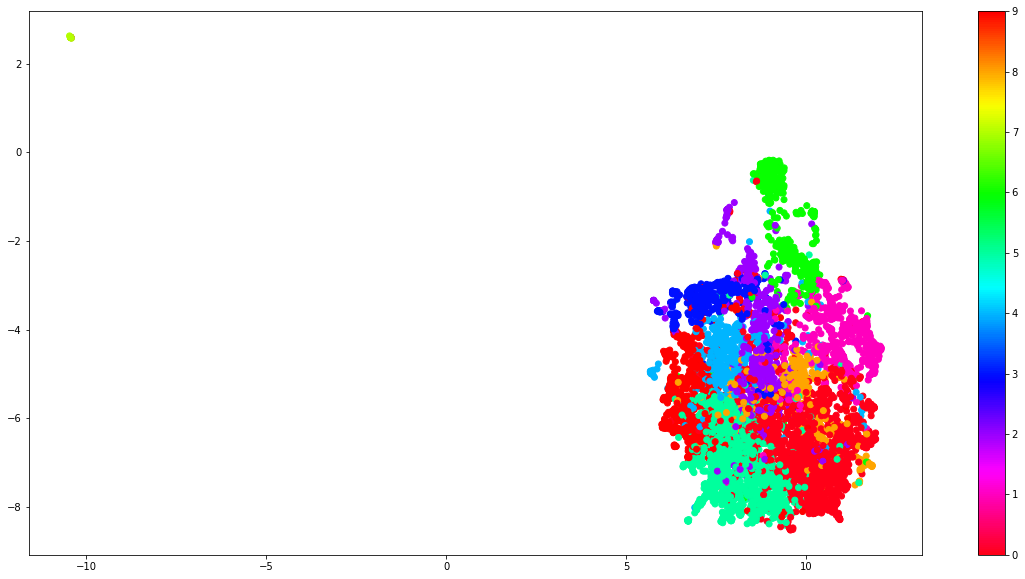

In [94]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
cluster2 = Birch(n_clusters=10).fit(umap_embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster2.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
plt.colorbar()

### Keyword extraction for each cluster

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

docs_cleaned=df['Description_cleaned']
docs_startups_urls=df['urlwebsite']

docs_df = pd.DataFrame(list(docs_cleaned), columns=["Doc"])
docs_df["urlwebsite"]=list(docs_startups_urls)
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(list(docs_cleaned)))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes

,Topic,Size
84,84,178
3,3,162
63,63,93
196,197,92
10,10,89
...,...,...
116,117,5
117,118,3
184,185,2
85,85,2


### Determine the topic of each cluster

In [ ]:
df_1 = pd.DataFrame(top_n_words)
df_1=df_1.applymap(lambda row: str(row[0])+":"+str(round(row[1], 2)))
df_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233
0,solar:0.23,improv:0.14,low:0.12,food:0.16,sport:0.14,mobil:0.21,pet:0.28,sport:0.41,famili:0.16,book:0.38,garden:0.11,french:0.22,turbin:0.29,smartphon:0.56,wed:0.16,environment:0.15,wine:0.57,home:0.35,health:0.21,tast:0.91,travel:0.09,bike:0.61,unleash:0.12,renov:0.58,parent:0.16,citi:0.24,intellig:0.3,wash:0.21,cater:0.27,energi:2.05,bio:0.16,home:0.43,health:0.37,secur:0.12,simpl:0.13,rental:0.31,estat:0.2,money:0.08,fix:0.53,100:0.36,...,tablet:0.3,music:0.26,video:0.25,3d:0.43,realiti:0.13,intellig:0.19,robot:0.31,command:0.34,mobil:0.2,tablet:0.74,wireless:0.28,laboratori:0.18,video:0.26,digit:0.45,recognit:0.84,detector:0.21,expert:2.12,sport:0.62,mobil:0.2,appl:0.19,innov:0.1,languag:0.33,artifici:0.31,digit:0.19,drone:0.73,china:0.53,connect:0.23,coach:0.24,lean:0.32,electr:0.31,mobil:0.15,music:0.93,child:0.36,right:0.13,10:0.13,digit:0.44,vr:0.25,bike:0.2,backup:0.27,leisur:0.17
1,light:0.22,sleep:0.11,pepper:0.09,restaur:0.12,reward:0.09,applic:0.09,cosmet:0.11,richer:0.14,friend:0.15,privat:0.26,organ:0.09,franc:0.18,wind:0.28,android:0.12,tourism:0.09,agricultur:0.12,fruit:0.14,build:0.11,medic:0.2,clicks:0.63,prospect:0.09,electr:0.29,posit:0.12,housework:0.36,pac:0.11,opportun:0.2,key:0.28,openairlin:0.08,hotel:0.22,expert:1.54,assum:0.11,hous:0.15,safeti:0.19,telephon:0.1,easi:0.08,rent:0.15,real:0.2,asid:0.08,homki:0.5,onlin:0.06,...,advertis:0.24,sound:0.21,mobil:0.19,print:0.16,game:0.13,artifici:0.14,intellig:0.11,act:0.3,app:0.18,smartphon:0.36,headset:0.13,creation:0.13,tim:0.07,physic:0.24,2d:0.82,measur:0.18,interact:2.03,footbal:0.1,develop:0.09,tag:0.18,special:0.09,translat:0.18,intellig:0.27,school:0.18,aerial:0.12,methodolog:0.25,low:0.23,tutor:0.17,travelogu:0.23,smart:0.25,applic:0.13,listen:0.62,young:0.14,smart:0.12,paramed:0.13,tv:0.4,360:0.2,uber:0.19,inventor:0.24,qweekl:0.13
2,weather:0.09,child:0.09,signag:0.08,deliveri:0.06,bestfootbal:0.09,brand:0.08,care:0.11,inv:0.13,share:0.13,booking:0.23,wast:0.08,100:0.07,sterblu:0.23,tv:0.09,hotel:0.08,electr:0.11,tast:0.1,iron:0.1,patient:0.11,mushroom:0.55,nearbi:0.09,bik:0.25,live:0.1,diy:0.34,babysitt:0.11,close:0.19,easi:0.24,eh:0.08,hospit:0.2,particular:0.64,newwind:0.11,accommod:0.14,sport:0.09,reduc:0.08,applic:0.05,owner:0.12,buy:0.17,click:0.08,2990:0.5,right:0.06,...,desrupt:0.21,audio:0.17,chatbot:0.17,virtual:0.12,augment:0.08,help:0.06,hellomybot:0.1,effect:0.28,smartphon:0.15,impair:0.19,bluetooth:0.13,interact:0.1,real:0.07,sublim:0.2,singl:0.63,optic:0.18,île:0.0,event:0.1,applic:0.09,plu:0.17,digit:0.08,learn:0.13,softwar:0.11,educ:0.16,inspect:0.1,studi:0.22,devic:0.2,wizard:0.12,journal:0.21,vehicl:0.18,trip:0.07,limit:0.47,citi:0.12,card:0.1,emerg:0.11,infrastructur:0.27,video:0.17,bicycl:0.18,moment:0.24,ticket:0.12
3,heat:0.09,smart:0.09,industri:0.07,meal:0.06,surfer:0.09,ultra:0.08,veterinari:0.11,mr:0.12,love:0.1,miam:0.23,veget:0.07,mate:0.05,aviat:0.21,io:0.09,book:0.07,energi:0.09,idealwin:0.09,nurs:0.09,hospit:0.11,visit:0.47,week:0.08,increas:0.16,career:0.09,check:0.3,child:0.1,need:0.16,voic:0.2,emiss:0.07,hotelquickli:0.11,advis:0.59,biomimet:0.1,servic:0.12,athlet:0.09,creat:0.08,allow:0.05,border:0.09,platform:0.11,delet:0.08,everyth:0.42,digit:0.05,...,stream:0.21,hear:0.11,wechat:0.13,realiti:0.08,simul:0.08,sphere:0.06,voicebot:0.1,better:0.27,android:0.12,white:0.19,lite:0.11,broadcast:0.1,platform:0.06,format:0.18,3d:0.55,radioact:0.17,fab:0.0,live:0.08,game:0.07,url:0.17,develop:0.08,blend:0.1,compani:0.09,learn:0.15,analysi:0.07,chine:0.22,protocol:0.19,train:0.11,devot:0.21,charg:0.14,crowd:0.07,everywher:0.46,disabl:0.11,simpl:0.09,gp:0.11,paytv:0.24,immers:0.12,urban:0.15,import:0.23,crm:0.12
4,sun:0.09,beauti:0.09,light:0.07,e

In [ ]:
docs_df[docs_df.Topic==211].head(20)

,Doc,urlwebsite,Topic,Doc_ID
61,sport experi place except,http://www.wepeaks.com,211,61
212,object connect sport,https://ouivallee.com,211,212
295,1 site sell object connect sport,http://www.sportsconnect.fr,211,295
342,1 compar offer sport equip club commun,https://www.lacentraledusport.fr,211,342
379,softwar onlin sport tournament manag,http://www.protournoi.fr,211,379
648,kapp10 mobil app share sport moment pictur vid...,http://kapp10.com,211,648
655,interact video player sport event,http://onrewind.tv,211,655
738,sport marketplac refer pro product,https://novatopo.com/,211,738
814,live stream sport match,https://www.swishlive.com/,211,814
895,1 websit 1 2 smartphon applic e-commerc site d...,https://lespepitestech.com/En%20maintenance,211,895
